# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 9 - Faktoryzacja QR
### Albert Gierlach

Użyta wersja pythona:

* Python 3.8.3 64bit

Użyte biblioteki:

* numpy 1.18.2
* matplotlib 3.2.1

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import random
import matplotlib as mtplt
from matplotlib import pyplot as plt

np.set_printoptions(precision=3)
mtplt.rcParams['figure.figsize'] = [18, 9] # plots size

#### 1. Faktoryzacja QR metodą Grama-Schmidta
Na podstawie podanego pseudokodu zaimplementowałem algorytm ortogonalizacji Grama-Schmidta.

In [3]:
def my_qr(A_orig):
    A = A_orig.copy()
    n = A.shape[0]
    Q = np.zeros(shape=A.shape, dtype=np.float64)
    R = np.zeros(shape=A.shape, dtype=np.float64)

    def norm_col(col):
        return col / np.linalg.norm(col)

    def back_sum(U, A, n):
        return sum((U[:, i].dot(A[:, n])) * U[:, i] for i in range(n))

    for k in range(0, n):
        Q[:, k] = norm_col(A[:, k] - back_sum(Q, A, k))

    for i in range(n):
        for j in range(i, n):
            R[i][j] = np.dot(Q[:, i], A[:, j])

    return Q, R

Później zaimplementowałem funkcję sprawdzającą zaimplementowany przeze mnie z algorytmem bibliotecznym.

In [4]:
def get_random_square_matrix(n):
    return np.random.rand(n, n)


def compare_matrices(A, B, eps=1e-6):
    return np.allclose(np.abs(A), np.abs(B), eps)


format_str = "|{:^5}|{:^17}|"
print(format_str.format("n", "my_qr == linalg"))
for i in range(5):
    n = random.randint(50, 300)
    A = get_random_square_matrix(n)
    qq, rr = my_qr(A)
    q, r = np.linalg.qr(A)

    equal = compare_matrices(qq, q) and compare_matrices(rr, r)
    print(format_str.format(n, "equal" if equal else "not equal"))

|  n  | my_qr == linalg |
| 291 |      equal      |
| 101 |      equal      |
| 129 |      equal      |
| 108 |      equal      |
| 93  |      equal      |


Następnie wygenerowałem 80 macierzy 8x8 z różnym wskaźnikiem uwarunkowania. Do tego celu użyłem faktoryzacji QR do znalezienia dwóch macierzy ortogonalnych oraz rozkładu SVD w celu znalezienia macierzy diagonalnej z malejącymi wartościami osobliwymi. Uwarunkowanie macierzy S jest realizowane poprzez zapewnienie, że pierwsza wartość na diagonali jest wielokrotnością ostatniej wartości na diagonali.

In [5]:
matrices_num = 80
n = 8

matrices = []
conds = []
for i in range(matrices_num):
    cond = random.randint(500, 2000)
    m1, m2, A = tuple(get_random_square_matrix(n) for _ in range(3))

    q1, _ = np.linalg.qr(m1)
    q2, _ = np.linalg.qr(m2)
    _, S, _ = np.linalg.svd(A)
    S[0] = cond * S[-1]

    matrices.append(q1 @ np.diag(S) @ q2)
    conds.append(cond)

W ostatnim kroku rozłożyłem wygenerowane macierze za pomocą zaimplementowanego algorytmu QR. Następnie przemnożyłem macierz \\(Q^T\\) przez \\(Q\\) i wynik odjąłem od macierzy identycznościowej. Z tak powstałej macierzy wyliczyłem normę, która oznacza błąd jaki powstał przy różnych wartościach wskaźnika uwarunkowania macierzy. Na wykresie przedstawiłem zależność współczynnika uwarunkowania od otrzymanego błędu.

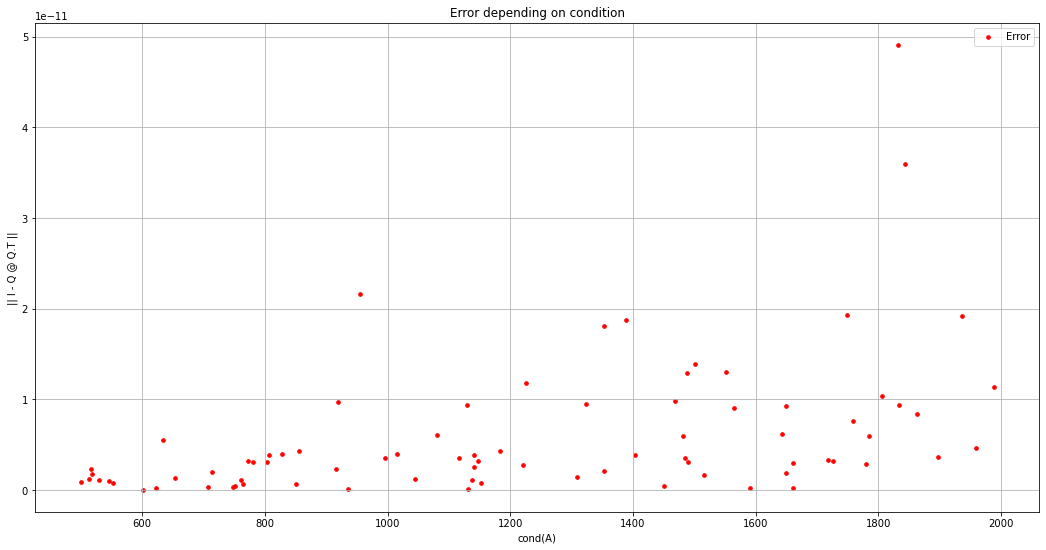

In [6]:
norms = []
for matrix in matrices:
    Q, _ = my_qr(matrix)
    norms.append(np.linalg.norm(np.identity(n) - (Q.T @ Q)))

plt.scatter(conds, norms, s=13, c="red")
plt.xlabel("cond(A)")
plt.ylabel("|| I - Q @ Q.T ||")
plt.legend(["Error"])
plt.title("Error depending on condition")
plt.grid()
plt.show()

Wykres przedstawia tendencję wzrostową. Im większy współczynnik uwarunkowania tym większy błąd obliczeń, czyli macierz Q traci swoją ortogonalność. Wynika to z tego, iż algorytm ortogonalizacji Grama-Schmidta staje się niestabilny numerycznie, czyli mały błąd obliczeń powoduje coraz to większe zaburzenia w dalszych krokach obliczeń.

#### 2. Rozwiązywanie układów równań metodą QR

W tym zadaniu mamy układ nadokreślony (mamy 3 niewiadome i 11 równań), więc musimy znaleźć taki zbiór parametrów, który minimalizuje błąd naszego rozwiązania. Rozwiązując to zadanie metodą QR minimalizujemy błąd średniokwadratowy i otrzymujemy dokładniejsze rozwiązanie.

Mając równanie postaci \\(Ax = y\\), możemy je rozwiązać w następujący sposób:
* rozkładamy macierz A metodą QR i otrzymujemy: \\(QRx = y\\)
* wiedząc, że \\(Q\\) jest ortogonalne mnożymy układ lewostronnie przez \\(Q^T\\) i otrzymujemy: \\(Q^TQRx = Q^Ty\\)
* ostatecznie otrzymujemy: \\(Rx = Q^Ty\\)

\\(A\\) jest macierzą obliczonych kolejnych potęg x w danym punkcie \
\\(y\\) to wartości funkcji w poszczególnych punktach \
\\(x\\) to wektor współczynników funkcji \\( f(x) = \alpha_0 + \alpha_1 x + \alpha_2 x^2 \\)

Poniżej zaimplementowałem obliczanie aproksymacji funkcji.

[13.972  0.182 -0.434]


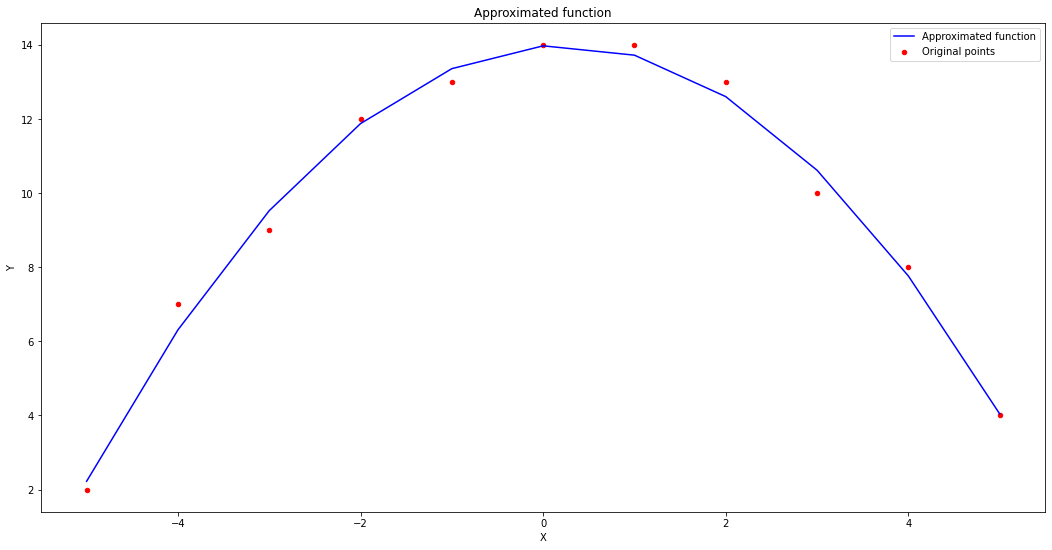

In [7]:
X = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], dtype=np.float64)
Y = np.array([2, 7, 9, 12, 13, 14, 14, 13, 10, 8, 4], dtype=np.float64)
A = np.array([[1, x, x ** 2] for x in X], dtype=np.float64)

Q, R = np.linalg.qr(A)
x = np.linalg.solve(R, Q.T @ Y)
print(x)

newY = list(map(lambda point: x[0] + (x[1] * point) + (x[2] * (point ** 2)), X))

plt.scatter(X, Y, s=20, c="red")
plt.plot(X, newY, c="blue")
plt.rc('axes', axisbelow=False)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Approximated function", "Original points"])
plt.title("Approximated function")
plt.show()

Jak widać rozwiązanie w dużym stopniu przybliża dokładniej kształt, który zakreślają pojedyncze punkty. Powyższą metodę można wykorzystać np. do dopasowania funkcji do wyników pomiarów. Jest bardzo skuteczna, gdyż aby rozwiązać układ wystarczy pomnożyć go przed odwrotnosć macierzy \\(R\\), a skoro jest to macierz ortogonalną to odwrotnością jest po prostu \\(R^T\\), co jest dużo szybsze niż obliczanie odwrotności w przypadku innych macierzy oraz redukuje błędy zaokrągleń, gdyż nie wykonujemy żadnych operacji arytmetycznych. 